# A/b Test 

### Objective 

We need to optimize our website, and one of the most important ways to do that is through A/B testng.  So for this exercise, we're going to be running an A/B test and making sure our results are sound and conclusions can be drawn.  

We're also going to try to automate some steps so that we can run many tests at the same time and not have to worry about analyzing them all manually.  Believe me, it saves a massive amount of time.

Let's talk about our data.  We have a hypothetical ecommerce website that offers different versions of the site in different languages.  Someone noticed that Spain users convert at a much higher rate than any other Spanish speaking country and we want to know why.  We have a hunch that it could be because the person who translated the site into Spanish is a Spain native.  Therefore, a way to figure this out would be to have a local translate the site for each Spanish speaking country.

Which is what we do, and the results come back different than we'd imagined.  The generic version, the first version which was written by a Spainiard and distrbuted to the rest of the countries, out performs the versions written by locals for their native countries.

What's up with that?  Are these tests really negative? We're going to take a look and explain why it might be happening to us and whether or not country specific site translations are really worse.

<u>Our Data includes:</u>
* File 1
    * General info about test results
        * user_id
        * date 
        * source
        * device
        * browser_language 
        * ads_channel
        * browser
        * conversion
        * test version
* File 2
    * User info
        * User id
        * Sex
        * Age
        * Country

Pretty standard stuff you'll see in any business database or analytics applcation

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data

In [92]:
user = pd.read_csv('../data/user_table.csv')

In [93]:
test = pd.read_csv('../data/test_table.csv')

In [94]:
user.dtypes

user_id     int64
sex        object
age         int64
country    object
dtype: object

In [96]:
test.dtypes

user_id              int64
date                object
source              object
device              object
browser_language    object
ads_channel         object
browser             object
conversion           int64
test                 int64
dtype: object

Let's convert date to datetime since it's just a string right now

In [98]:
#converting the dtype of 'date' column to datetime
test['date'] = pd.to_datetime(test['date'])

In [44]:
len(user.user_id) - len(test.user_id) 

-454

These are the users that are in the test test that aren't in the user table

In [101]:
set(test.user_id)-set(user.user_id)

{1524,
 6942,
 7557,
 8248,
 9826,
 10338,
 16574,
 20338,
 23032,
 36811,
 40430,
 41234,
 54350,
 55244,
 62626,
 64563,
 64835,
 68021,
 69200,
 70173,
 72592,
 72738,
 75126,
 75387,
 83590,
 84309,
 84772,
 87027,
 87209,
 87474,
 88423,
 89918,
 89931,
 91508,
 92193,
 92224,
 95515,
 99374,
 100378,
 101605,
 105690,
 110422,
 112821,
 113954,
 114215,
 117389,
 120325,
 120795,
 123409,
 125268,
 126484,
 127404,
 127935,
 128162,
 129021,
 131944,
 132599,
 136206,
 136246,
 142848,
 145613,
 148475,
 148697,
 149821,
 151510,
 155569,
 157541,
 166846,
 167046,
 167627,
 171062,
 171189,
 172428,
 172474,
 173737,
 175940,
 180446,
 181003,
 181219,
 182967,
 183626,
 187916,
 188768,
 191496,
 192915,
 194065,
 195911,
 199006,
 199752,
 200612,
 201405,
 203802,
 206462,
 207956,
 211909,
 212582,
 212796,
 214742,
 215754,
 218260,
 220026,
 220116,
 220613,
 220734,
 223459,
 224518,
 224866,
 228570,
 235537,
 239994,
 241026,
 241216,
 241964,
 243689,
 248612,
 248957,

In order to maintain our data integrity and not lose those 454 ids only in the test, let's do a left/right join instead of an inner join

* separate files are fine, but let's combine them.  It'll be easier to clean and preprocess when they're together

In [102]:
df = pd.merge(left=test, right=user, left_on='user_id', right_on='user_id', how='left')

In [103]:
# Check for null values
df.isnull().any()

user_id             False
date                False
source              False
device              False
browser_language    False
ads_channel          True
browser             False
conversion          False
test                False
sex                  True
age                  True
country              True
dtype: bool

In [104]:
df.dtypes

user_id                      int64
date                datetime64[ns]
source                      object
device                      object
browser_language            object
ads_channel                 object
browser                     object
conversion                   int64
test                         int64
sex                         object
age                        float64
country                     object
dtype: object

In [105]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [106]:
df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


### Exploratory Analysis

In [107]:
categorical_vars = ['source','device','ads_channel','browser','sex','country']

In [108]:
def plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png'):
    plt.rcParams['figure.figsize'] = (16, 14)
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=45)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

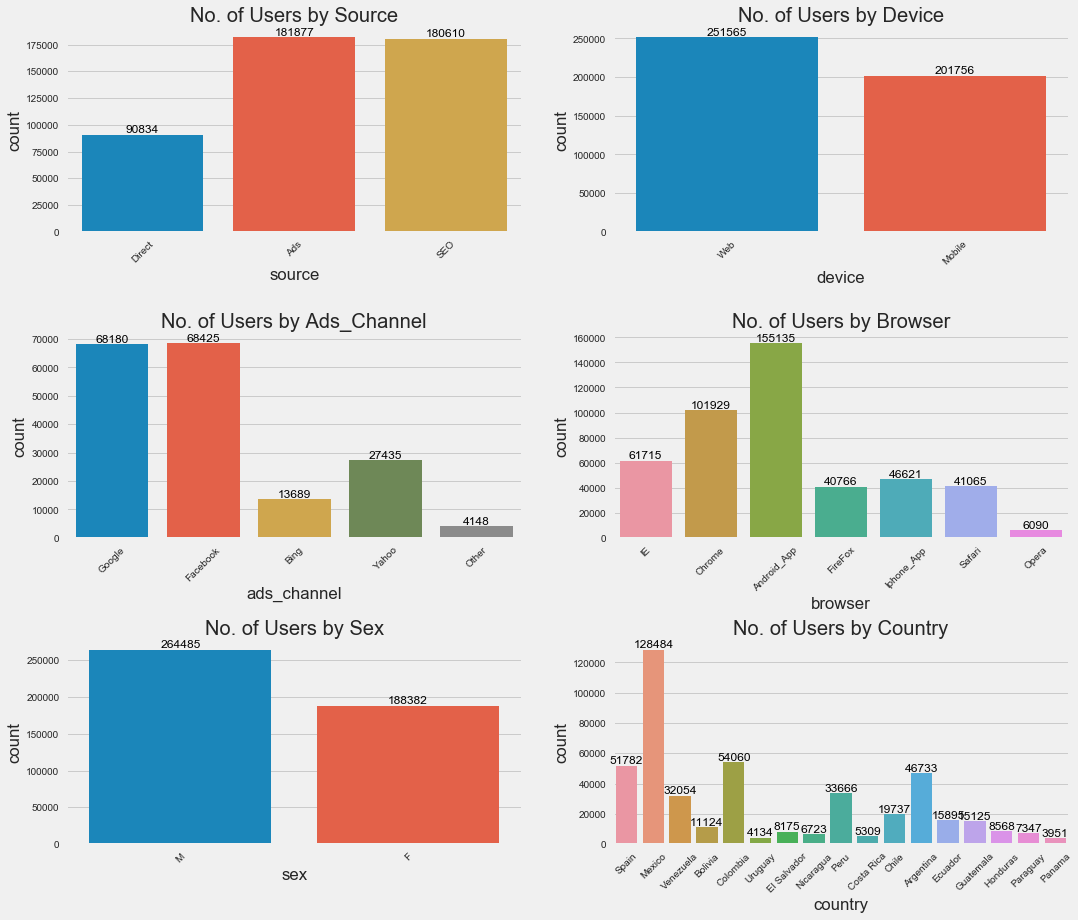

In [109]:
plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png')

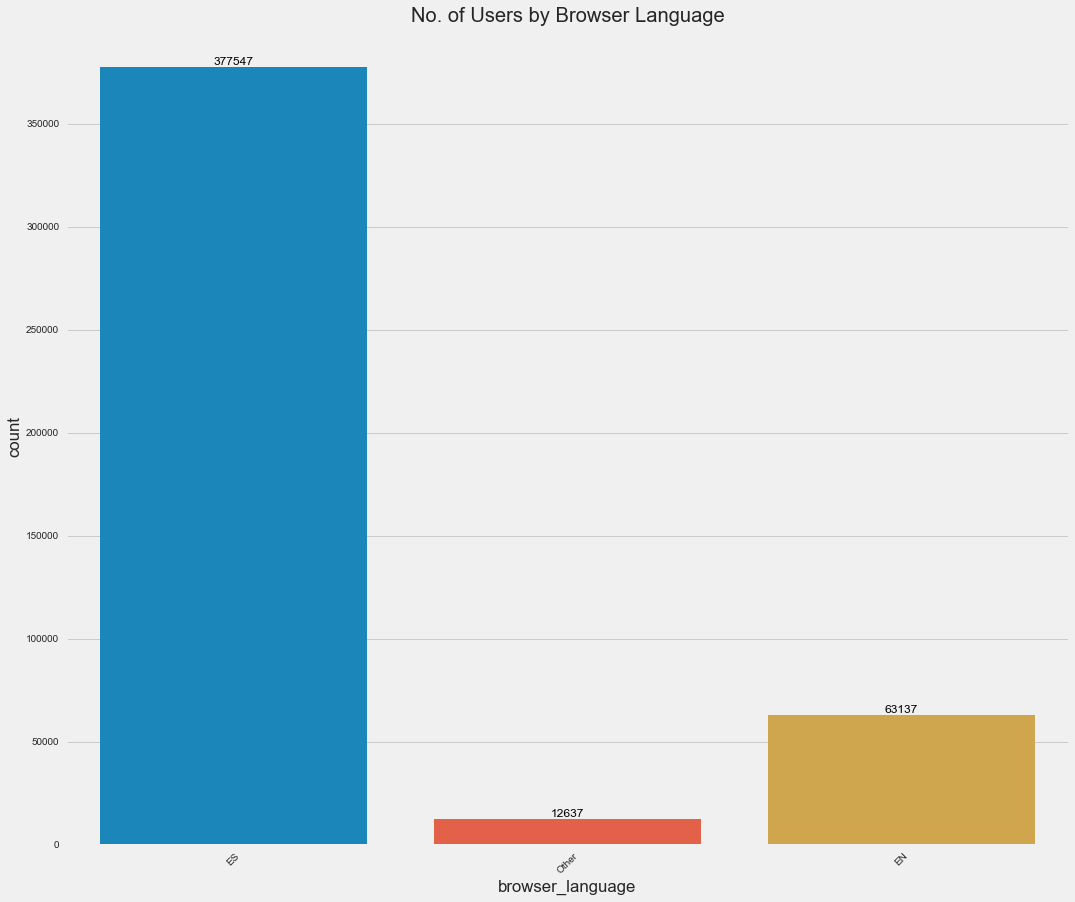

In [110]:
plt.subplots_adjust(hspace=.5)
sns.countplot(x='browser_language',data = df)
plt.xticks(rotation=45)
plt.title(str("No. of Users by Browser Language"))
# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/count_browser_language.png')

In [111]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns[1:]

Index([u'conversion', u'test', u'age'], dtype='object')

In [112]:
numeric_vars = ['conversion','age']

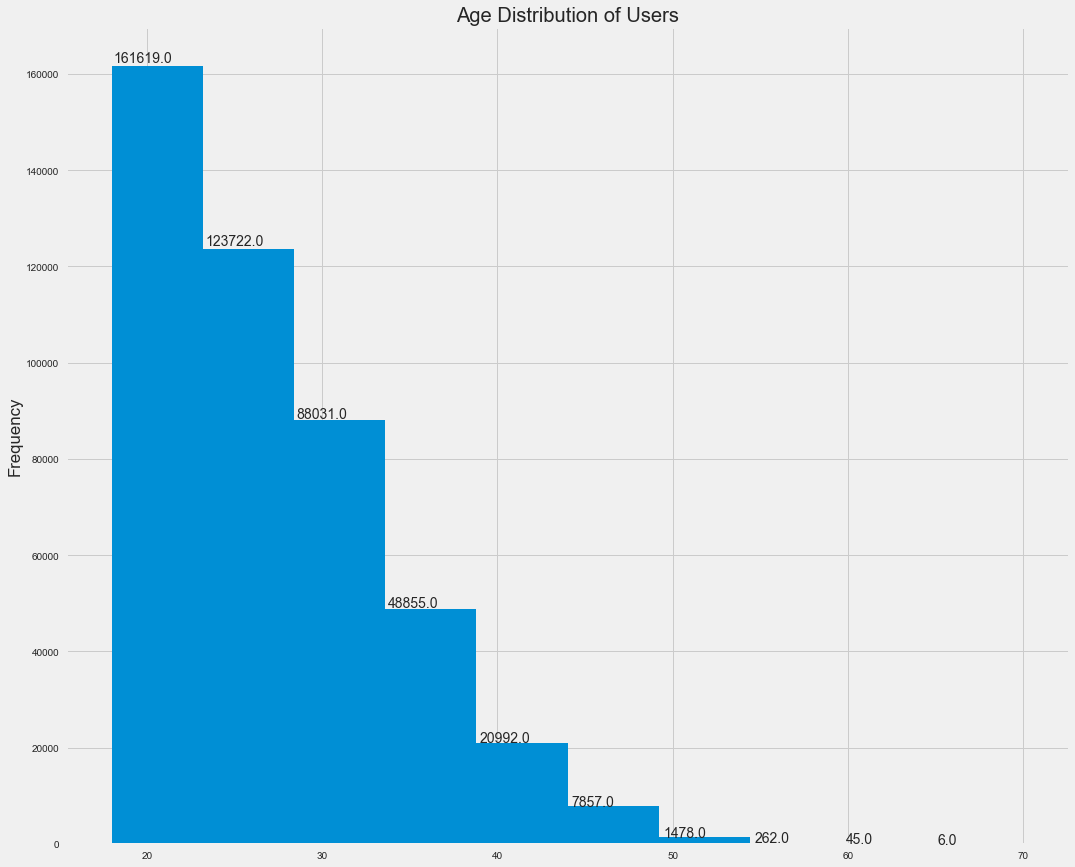

In [113]:
ax = df.age.plot(kind = 'hist', title = 'Age Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/age_distribution_of_users.png')

Now let's check to make sure conversion rate converts best in Spain, which would show our data is lining up correctly

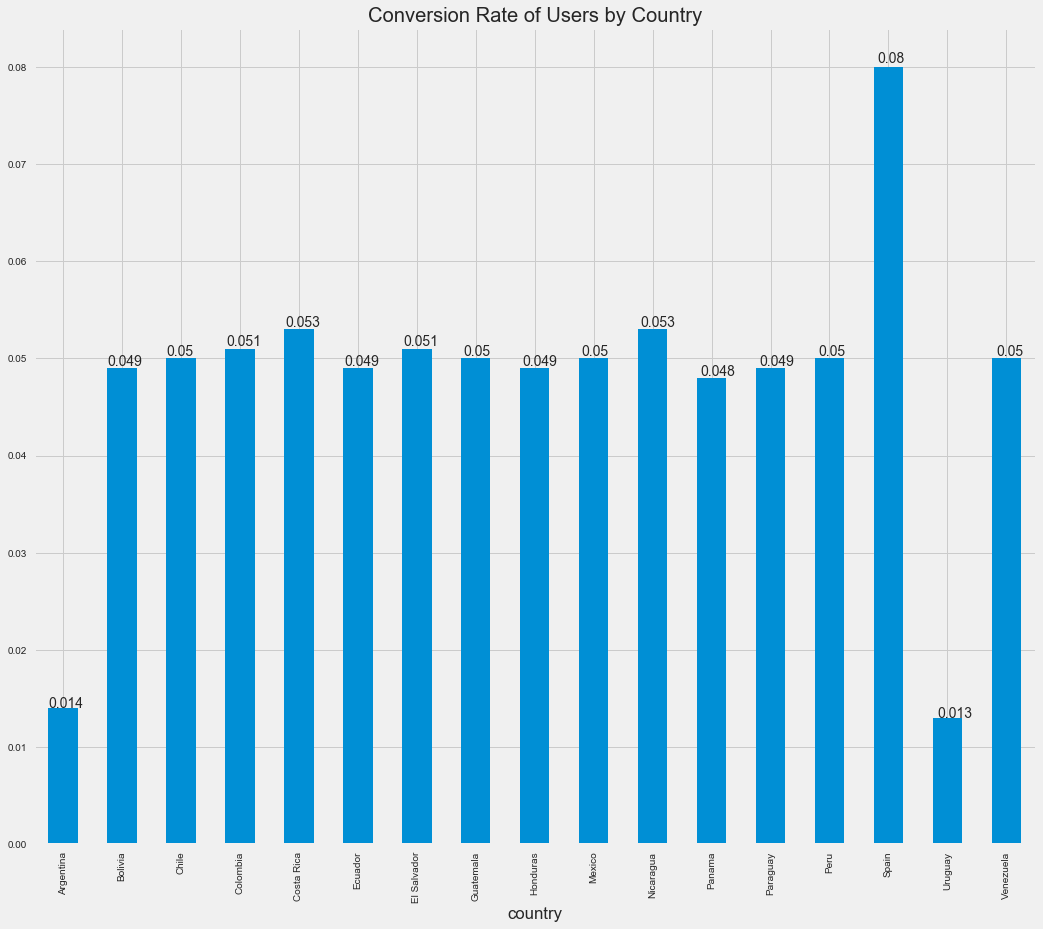

In [114]:
# df.groupby('country')['conversion'].mean().plot(kind='bar')
ax = df.groupby('country')['conversion'].mean().astype(float).round(3).plot(kind = 'bar', title = 'Conversion Rate of Users by Country')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/conversion_rate_of_users_by_country.png')

From this graph we can see:

* Spain clearly converts the best
* And If we remember from before, Argentina has the 4th highest user base, and now we're seeing that it has one of the worst conversion rates.

So I would go back to the exec team and tell them that we should start with improving Argentina's conversion rate.

### Let's dig a little deeper

In [119]:
# Let's find out how long our dataset was collected.
print df.date.max() - df.date.min()
print df.date.max()
print df.date.min()

4 days 00:00:00
2015-12-04 00:00:00
2015-11-30 00:00:00


Looks like the entire dataset or the test itself was conducted for 5 days. This could be helpful information later on

Let's also make sure Spain's conversion rate is not by chance. To do this we'll run an experiment using a control and treatment set.  We need to make sure Spain is not included in our control set.

In [125]:
df[df['country']!='Spain'].groupby('test')['conversion'].mean().reset_index()

,test,conversion
0,0,0.048330
1,1,0.043425


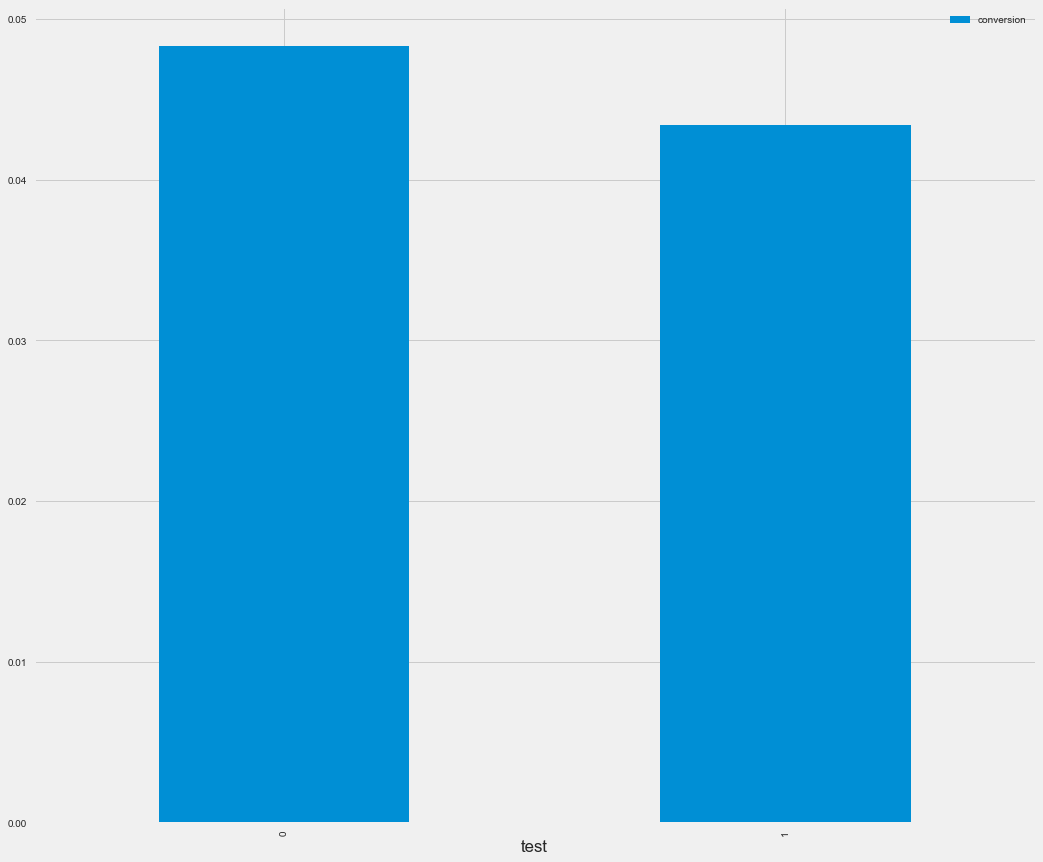

In [131]:
df[df['country']!='Spain'].groupby('test')['conversion'].mean().reset_index().plot(kind='bar', x='test',y='conversion')

Okay so what's going on above?

* We see that the control conversion rate is 4.8% while the test conversion rate is 4.3%.  Let's see if there is any dirty data in our set, or data that could be biasing our set and could explain the decrease in conversion rate between our test and control set.

* Could it be due to geography? Time - was this data collected on a weekend or holiday? Channel? Age? Who knows, not us currently, but since we know that this data was collected for 5 days, we could make an educated guess that we might just be lacking enough data.  Let's check it out though.

* Let's start by plotting the distribution of each feature for test and control data.


In [154]:
# final_df = df[df.country != 'Spain']
final_df = df[(df.country != 'Spain') & (df.browser_language == 'ES')]

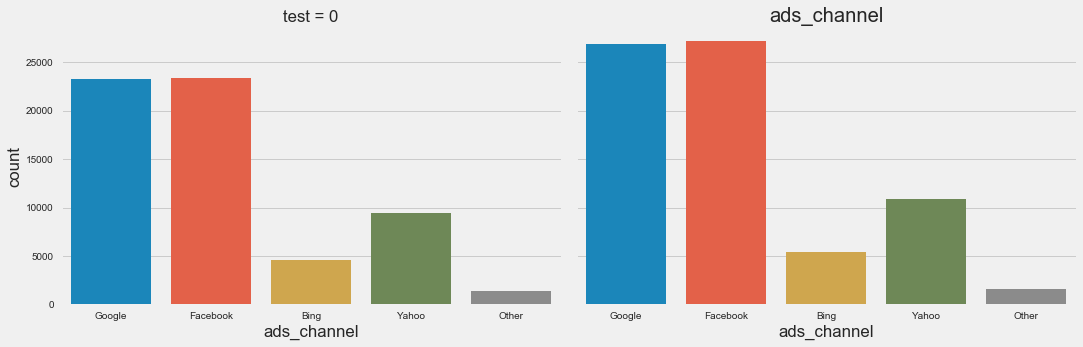

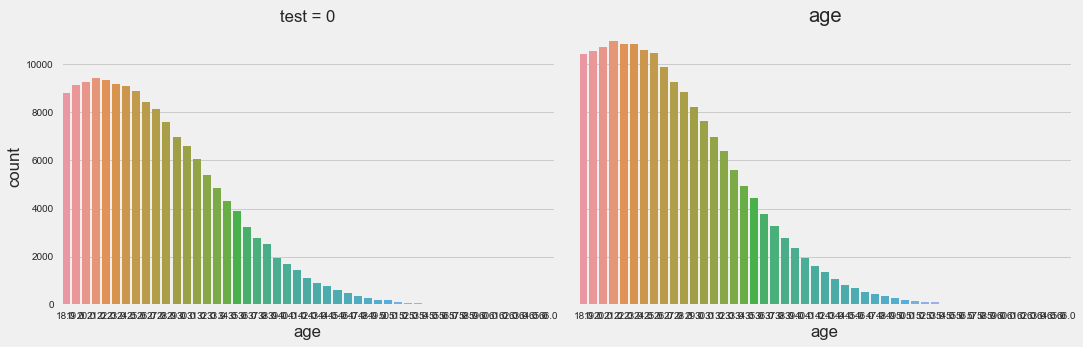

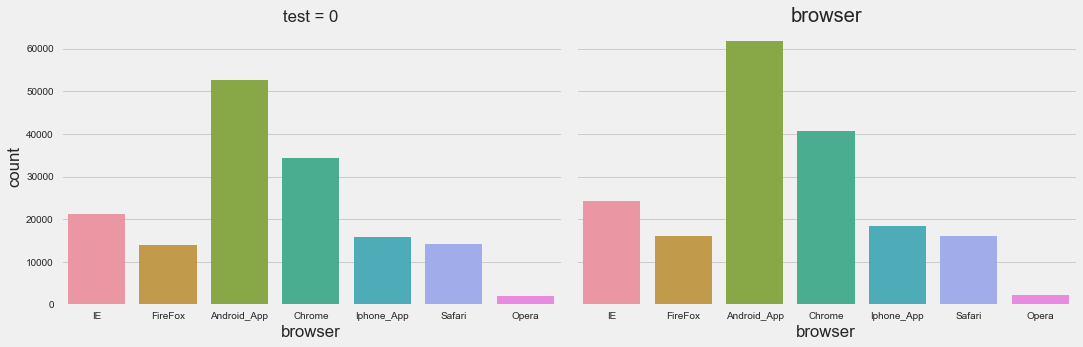

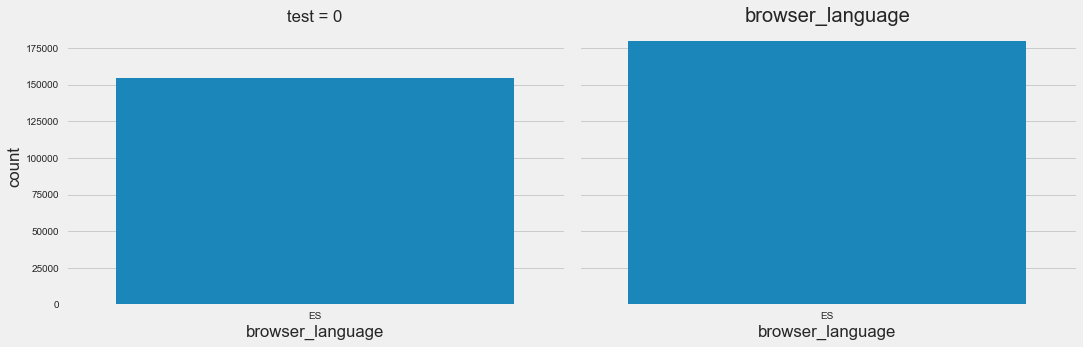

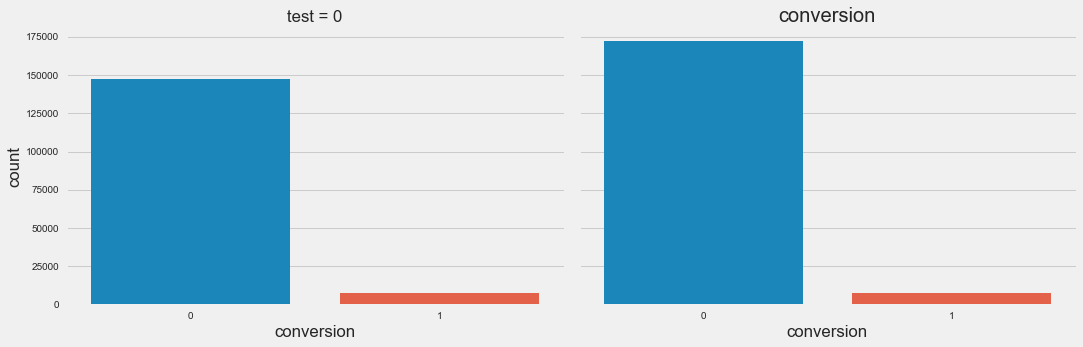

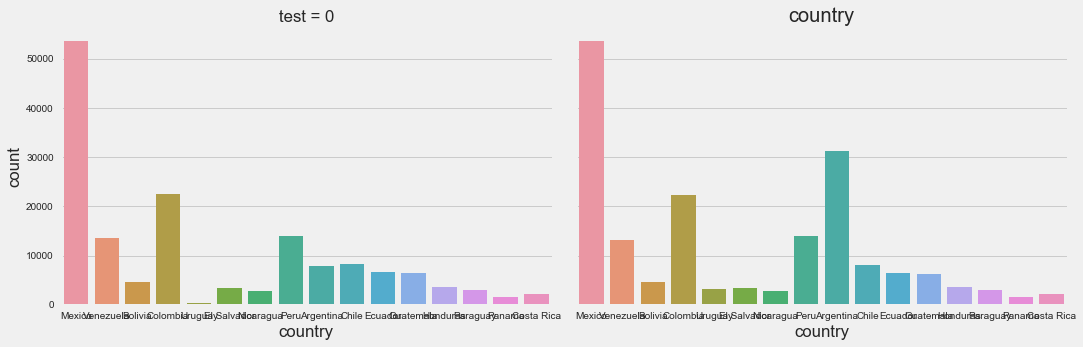

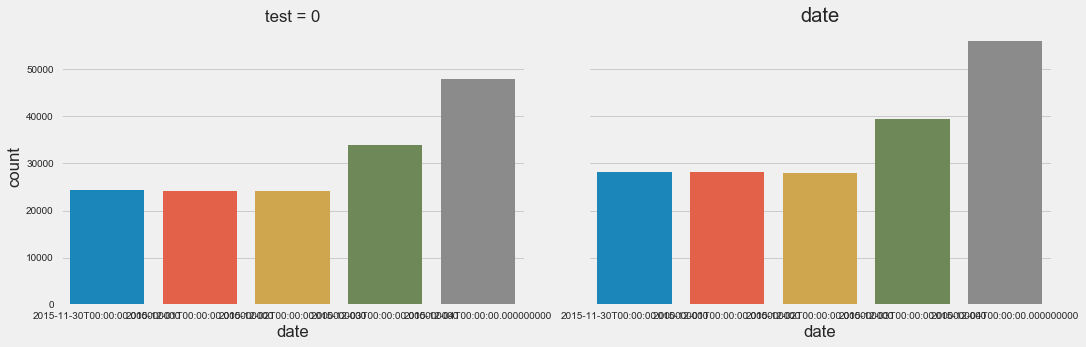

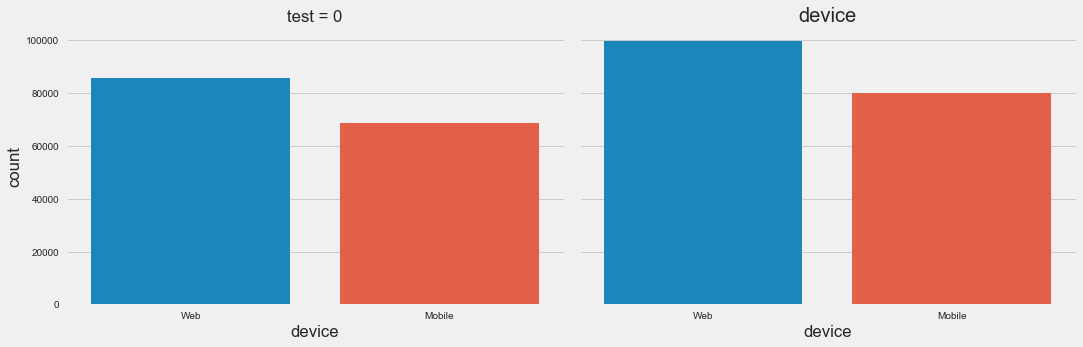

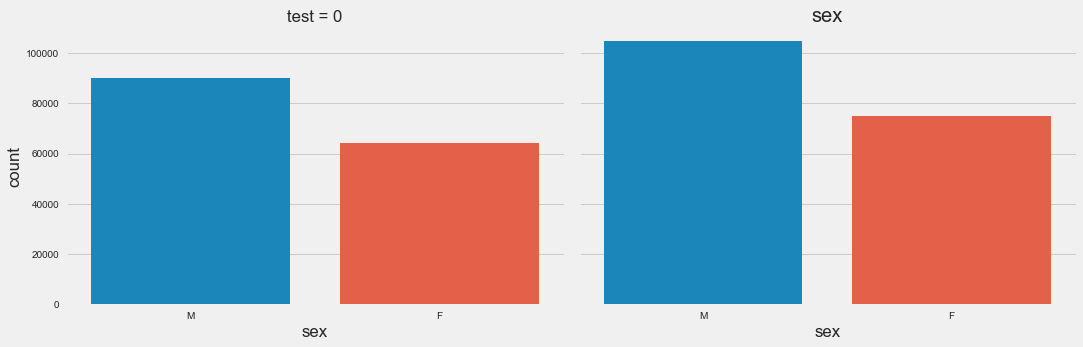

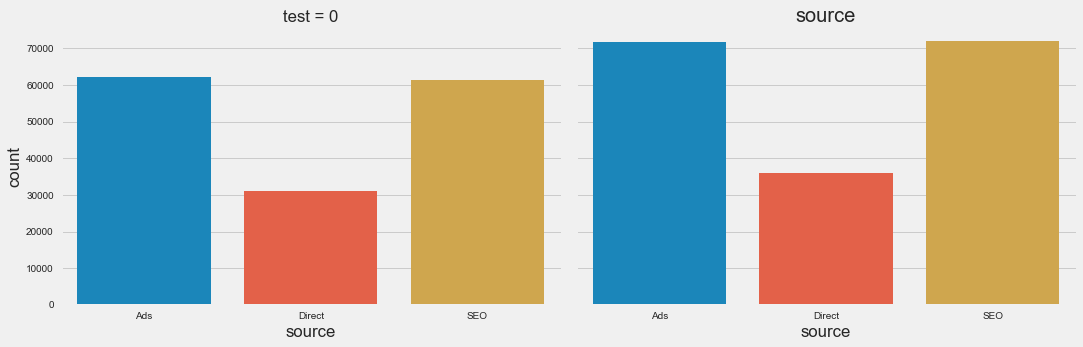

In [155]:
for i in final_df.columns.difference(['user_id', 'test']):
    plt.rcParams['figure.figsize'] = (16, 14)
    sns.factorplot(i, data = final_df, kind = 'count', col = 'test', size = 5, aspect = 1.5)
    plt.title(i)
    # Get current axis on current figure
#     ax = plt.gca()
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.savefig('../figures/factor_plot_'+i+'.png')

In [211]:
df.groupby(['date','country'])['conversion'].mean()

date        country    
2015-11-30  Argentina      0.013258
            Bolivia        0.054354
            Chile          0.047774
            Colombia       0.055793
            Costa Rica     0.053140
            Ecuador        0.055755
            El Salvador    0.063729
            Guatemala      0.047393
            Honduras       0.054613
            Mexico         0.051532
            Nicaragua      0.045412
            Panama         0.049206
            Paraguay       0.052028
            Peru           0.048118
            Spain          0.078798
            Uruguay        0.012638
            Venezuela      0.054265
2015-12-01  Argentina      0.013502
            Bolivia        0.048891
            Chile          0.048142
            Colombia       0.048401
            Costa Rica     0.048349
            Ecuador        0.041650
            El Salvador    0.045914
            Guatemala      0.047127
            Honduras       0.046910
            Mexico         0.048987
    

A couple notes:
* We can see from the above that there are not any significant differences between the control and test data. 
* We see a little difference in age and country 
    * There are more users from Argentina in the test set than control set

Let's revisit the null values and see if we should get rid of any rows or engineer new features from it

In [156]:
final_df.dropna(subset=['sex', 'age','country'], inplace=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


We still have a bunch of nulls in the ads channel column, so let's make a new feature that addresses though

In [157]:
final_df['ads_channel_null'] = np.where(final_df['ads_channel'].isnull(), 1, 0)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [158]:
#We are performing a numerical encoding to the categorical features, using the sklearn label encoder.
for feature in ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex']:
    lbl_enc = LabelEncoder()
    lbl_enc.fit(final_df[feature])
    final_df[feature] = lbl_enc.transform(final_df[feature])
    if feature == 'country':
        cnt = list(lbl_enc.inverse_transform(final_df[feature]))

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [159]:
final_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,ads_channel_null
1,497851,2015-12-04,0,1,0,3,3,0,1,1,21.0,9,0
4,548435,2015-11-30,0,1,0,3,2,0,1,1,19.0,9,0
5,540675,2015-12-03,1,0,0,0,0,0,1,0,22.0,15,1
8,261625,2015-12-04,1,0,0,0,0,0,1,1,31.0,1,1
9,10427,2015-12-04,0,0,0,2,0,0,0,0,33.0,9,0


In [178]:
# Let's fit a Random Forest and check the feature importance
feature = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex', 'age']
model = RandomForestClassifier()
#model.fit(map(lambda x: [x],comp_df[features]),comp_df['test'])
model.fit(final_df[feature], final_df['test'])
importances = model.feature_importances_

In [179]:
print importances
np.argsort(importances)[::-1]

[ 0.          0.48904115  0.03822892  0.03384321  0.00119752  0.00774064
  0.00730325  0.42264531]


array([1, 7, 2, 3, 5, 6, 4, 0])

In [180]:
final_df[feature].columns[1]

'country'

In [166]:
X = final_df[feature]

In [174]:
X.shape[1]

8

In [188]:
print importances[indices[0]]
print indices[0]
print importances[1]
print X.columns[1]

0.489041145691
1
0.489041145691
country


Feature ranking:
feature browser_language (0.000000)
feature country (0.489041)
feature browser (0.038229)
feature ads_channel (0.033843)
feature device (0.001198)
feature source (0.007741)
feature sex (0.007303)
feature age (0.422645)


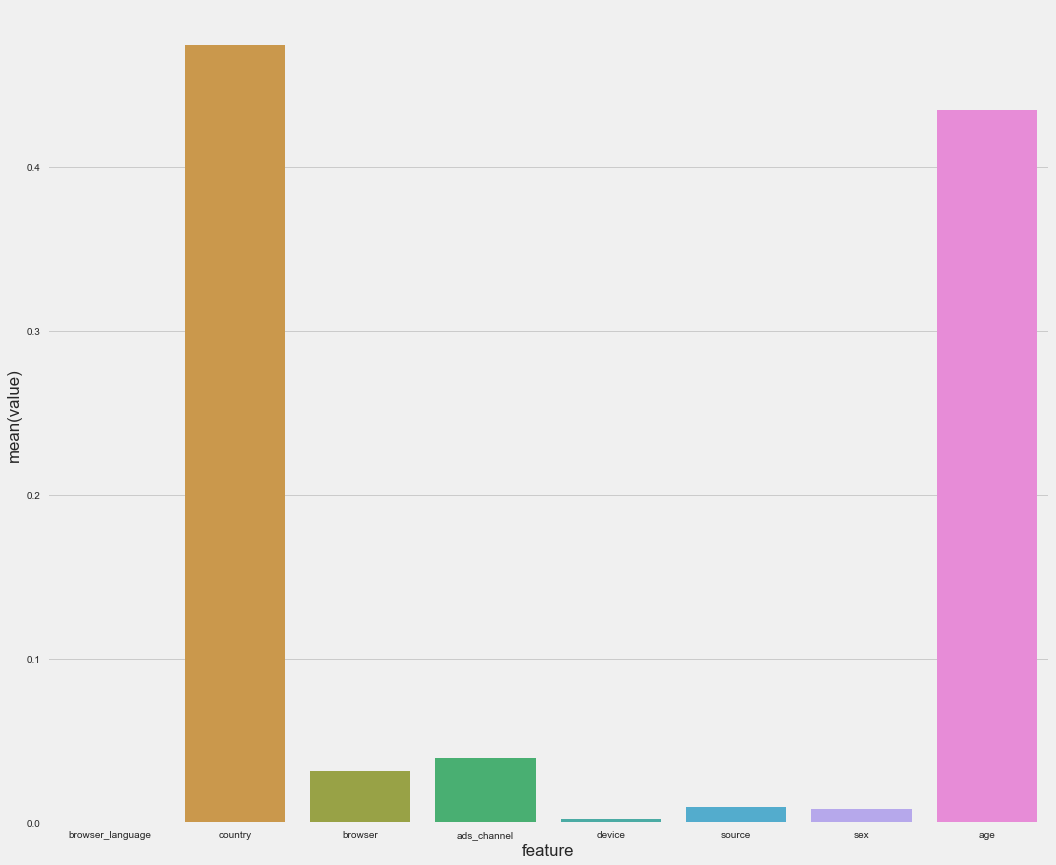

In [198]:
forest = model
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("feature %s (%f)" % ( X.columns[f], importances[f]))
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
sns.barplot(x='feature', y ='value', data=importance)

Looks like age and country have the maximum impact on the result. Let us quickly check if these are causing any bias.

We'll run a basic T-Test to verify and see that if it is indeed the demographical distribution of the control and test data segment results.

In [153]:
final_df['country'] = cnt
country = []
conversion_test = []
conversion_control = []
p_vals = []
ttest_vals = []
for i in final_df.country.value_counts().index:
    temp = final_df[final_df.country == i]
    cat1 = temp[final_df.test == 1].conversion
    cat2 = temp[final_df.test == 0].conversion
    ttest, p =stats.ttest_ind(cat2, cat1)
    country.append(i)
    conversion_test.append(cat1.sum()/float(len(cat1)))
    conversion_control.append(cat2.sum()/float(len(cat2)))

    ttest_vals.append(ttest)
    p_vals.append(p)
    
pd.DataFrame({'country': country, 
              'conversion_test': conversion_test,
              'conversion_control': conversion_control,
             'p_value': p_vals})\
[['country', 'p_value', 'conversion_test', 'conversion_control']]

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,country,p_value,conversion_test,conversion_control
0,Mexico,0.165547,0.051186,0.049495
1,Colombia,0.423733,0.050571,0.052089
2,Argentina,0.321766,0.013725,0.015071
3,Peru,0.771950,0.050604,0.049914
4,Venezuela,0.573740,0.048978,0.050344
5,Chile,0.302871,0.051295,0.048107
6,Ecuador,0.961512,0.048988,0.049154
7,Guatemala,0.572165,0.048647,0.050643
8,Bolivia,0.718877,0.047901,0.049369
9,Honduras,0.471721,0.047540,0.050906


In [200]:
t_test_df = final_df[['age', 'test']].dropna()
cat1 = t_test_df[t_test_df.test == 1].age
cat2 = t_test_df[t_test_df.test == 0].age

ttest, p =stats.ttest_ind(cat1, cat2)
print 't-test independent', ttest
print p

t-test independent -1.12191297811
0.261900248535


From both of these t-tests, we can see that our p-values are not strong enough to conclude that the difference in translation had any effect on conversion.  Basically when we controlled for country and their respective localized translation, we didn't see a significant change in the conversion rate.

### Conclusion
* The test that we conducted to see if local translations had increased conversion rates showed that it did not have a great effect in increasing conversion rate.  Or actually for that matter a decreasing conversion rate was not seen either.  
* One suggestion would be to let the test run a little longer.
